Leer Texto de imagenes

In [20]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import csv
import matplotlib.pyplot as plt
import cv2
import os
import torch

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


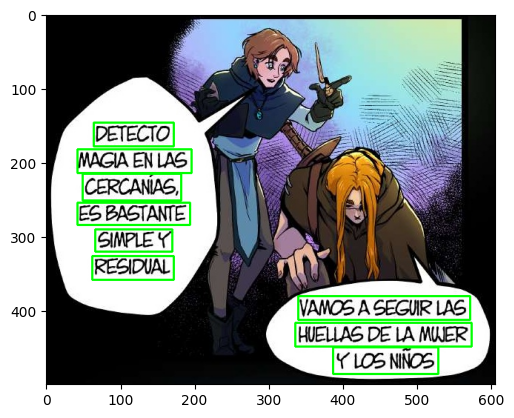

e:\ANACONDA\envs\SATURDAYS-2\Lib\site-packages\transformers\generation\utils.py:1283: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
e:\ANACONDA\envs\SATURDAYS-2\Lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Resultado total de EasyOCR: DETECTO MACIA ENLAS CERCANIAS; ES BASTANTE SIMPLEY RESIDUAL VAMOS A SECUIR LAS HUELLASDE LA MUER {LOSNIÑS
Resultado total de TrOCR: DE TECTO NAGIA EN LAS CERCONAS, ES BAS TANTE SIMPLE Y RESIDUAL VANOS A SEGUR LAS HUELIAS DE MUER Y LOS NIOS
Resultado de TrOCR guardado en: ..\..\data\output\output_text_test\panel_2.txt


In [23]:
# Inicializar el procesador y el modelo de TrOCR
processor = TrOCRProcessor.from_pretrained(r'..\..\train\models\procesador_finetuneado_trOCR')
model = VisionEncoderDecoderModel.from_pretrained(r'..\..\train\models\modelo_finetuneado_trOCR')

# Inicializar el lector de EasyOCR
reader = easyocr.Reader(['es'])  # Puedes agregar otros idiomas si es necesario

# Cargar la imagen
image_path = r'..\..\data\output\divide_images_test\Chapter01\page3_img\panel_2.jpg'
image = cv2.imread(image_path)

# Detectar texto en la imagen
result = reader.readtext(image)

# Mostrar las áreas detectadas
for (bbox, text, prob) in result:
    # Extraer las coordenadas del bounding box
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    top_right = tuple(map(int, top_right))
    bottom_right = tuple(map(int, bottom_right))
    bottom_left = tuple(map(int, bottom_left))

    # Dibujar el bounding box en la imagen
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

# Mostrar la imagen con los bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Función para recortar una región de la imagen
def crop_image(image, bbox):
    top_left, top_right, bottom_right, bottom_left = bbox
    x_min = min(top_left[0], bottom_left[0])
    x_max = max(top_right[0], bottom_right[0])
    y_min = min(top_left[1], top_right[1])
    y_max = max(bottom_left[1], bottom_right[1])
    return image[y_min:y_max, x_min:x_max]

# Variables para almacenar los textos concatenados
easyocr_text_total = ""
tocr_text_total = ""

# Procesar cada región detectada con TrOCR
for (bbox, text, prob) in result:
    cropped_image = crop_image(image, bbox)
    pil_image = Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

    # Preprocesar la imagen
    pixel_values = processor(pil_image, return_tensors="pt").pixel_values

    # Realizar el reconocimiento de texto
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Concatenar los resultados
    easyocr_text_total += text + " "
    tocr_text_total += generated_text + " "

# Mostrar los resultados concatenados
print(f'Resultado total de EasyOCR: {easyocr_text_total.strip()}')
print(f'Resultado total de TrOCR: {tocr_text_total.strip()}')

# Extraer el nombre del archivo de la imagen sin la extensión
image_name = os.path.splitext(os.path.basename(image_path))[0]

# Crear el nombre del archivo de texto
text_file_path = f"..\\..\\data\\output\\output_text_test\\{image_name}.txt"

# Guardar el resultado de TrOCR en el archivo de texto
with open(text_file_path, "w", encoding="utf-8") as text_file:
    text_file.write(tocr_text_total.strip())

print(f'Resultado de TrOCR guardado en: {text_file_path}')